<img src="https://i2.wp.com/www.ai-claudio.com/wp-content/uploads/2017/05/keras-tensorflow-logo.jpg?resize=500%2C201"/>

## Import modules 


In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from tqdm import tqdm
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, MaxPooling1D, TimeDistributed
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Keras Model Parameters

In [2]:
epochs = 20
batch_size = 64
n_steps, n_length = 7, 26

# Function for loading data from our 1D dataset

In [3]:
def loadData():
    # Load HDF5 dataset
    with h5py.File('data/dataset1D.hdf5', 'r') as f:
        X = f['X'].value
        Y = f['Y'].value
    
    #Split data to train/val/test sets with percents 70%/20%/10%
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.30)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.33)

    return (x_train, y_train),(x_val,y_val),(x_test,y_test)

# Load Image Data
### Two classes of particles: electrons and photons 
### Data was converted from a 32x32x2 image to a 128x1 time series
### Data reshaping is done to fit network

In [4]:
_,_,(x_test,y_test) = loadData()
x_test = x_test.reshape((x_test.shape[0], n_steps, n_length, 1))

c:\users\madef\appdata\local\programs\python\python36\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


## Define CNNLSTM Model

In [5]:
### Define CNNLSTM Model ###

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,26,1)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 24, 64)      256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 22, 64)      12352     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 22, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 11, 64)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 704)         0         
_________________________________________________________________
lstm_1 (LSTM)        

### Classify using our network

In [6]:
#Load model
model.load_weights("data/model.hdf5")

#Here we classify class 0 as an output less than 0.5 and class 1 is 0.5 o 1.0
output = model.predict(x_test)
prediction = np.array(output >= 0.5, dtype=float)

fpr, tpr, _ = roc_curve(y_test, prediction)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

Test ROC AUC: 0.6433768213351078


No handles with labels found to put in legend.


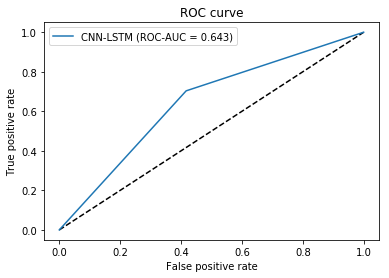

In [7]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='CNN-LSTM (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()